# **Fine-tuning Self-supervised Models with SpeechBrain**


This tutorial will guide you through the process of **fine-tuning pretrained models** that are available in the HuggingFace Transformers library. These models include *Whisper*, *wav2vec 2.0*, *HuBERT*, *WavLM*, and many others. By using **SpeechBrain**, you can easily utilize these pretrained models to tackle speech- or audio-related tasks such as automatic speech recognition, speaker recognition, spoken language understanding, and emotion recognition.

Pre-training large self-supervised models is a complex process due to various reasons, including the requirement of significant resources such as dozens of GPUs for several hours, and the challenge of ensuring replicability due to the intricacies of the pipeline.


**Architectures of interest for this tutorial**
We will only consider one of the most up-to-date existing pretrained model: wav2vec 2.0. However, SpeechBrain support many others, including wavLM and HuBERT.  

Wav2Vec is a transformer-based encoder architecture enabling self-supervised representation learning of speech. Please refer to the official paper to obtain more details: [wav2vec2](https://arxiv.org/abs/2006.11477).

<img src="https://miro.medium.com/max/2300/0*CdcN0iV_39yEOPeF" alt="drawing" width="700"/>

*Illustration of Wav2vec2, [source](https://medium.com/georgian-impact-blog/how-to-make-an-end-to-end-automatic-speech-recognition-system-with-wav2vec-2-0-dca6f8759920).*


**With this tutorial, you will learn how to:**
1. Instantiate a wav2vec2 and extract self-supervised features from an audio file.
2. Fine-tune wav2vec2 on your downstream task of interest.



Let's first install all the needed packages:

In [1]:
%%capture
!git clone https://github.com/speechbrain/speechbrain.git
%cd speechbrain
!pip install -r requirements.txt
!pip install .
%cd ..

We also need to install the HuggingFace Transformers interface:

## **1. Compute features with Wav2Vec 2.0**


Finally, let's also download and load an audio file to play with.

In [2]:
%%capture
!wget https://www.dropbox.com/s/u8qyvuyie2op286/spk1_snt1.wav

In [3]:
import speechbrain as sb

signal = sb.dataio.dataio.read_audio('spk1_snt1.wav').squeeze()
print(signal.shape)


torch.Size([45920])


This is the imported signal:

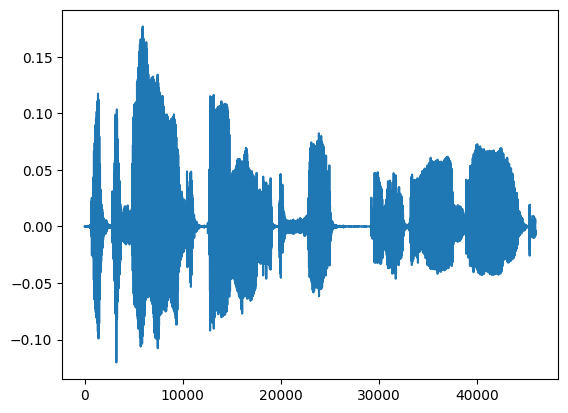

In [4]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(signal)
plt.show()

from IPython.display import Audio
Audio('spk1_snt1.wav')

Wav2vec2 is offered as a **lobe** in SpeechBrain. Its implementation can be found in `speechbrain.lobes.models.huggingface_wav2vec.py`.


Now, we instantiate it. There will be some warnigs, but you can ignore them.

In [5]:
from speechbrain.lobes.models.huggingface_transformers.wav2vec2 import Wav2Vec2

model_hub_w2v2 = "facebook/wav2vec2-base-960h"
model_w2v2 = Wav2Vec2(model_hub_w2v2, save_path='/content/pretrained/')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

Here, we can explore the model with:

In [6]:
print(model_w2v2)

Wav2Vec2(
  (model): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Wav2Vec

Now, we can try to extract audio features from those models! In our examples however, we have two different models that require different forward operations if our goal **solely is to retrieve the latent representation of the audio input.** Wav2vec 2.0 is a transformer encoder, so we just need to get the output of the last layer. Whisper, on the other end, is packaged as a fully trained encoder-decoder. **Hence, we must make sure that we only retrieve the output of the encoder!**

In [7]:
print(signal.shape)
fea_w2v2 = model_w2v2(signal.unsqueeze(0))
print(fea_w2v2.shape)


torch.Size([45920])
torch.Size([1, 143, 768])


**What am I looking at?**

These features correspond to the Context Representation obtained after the transformer (See the *C* in the initial wav2vec2 illustration). Hence, this output dimension is *768* for the Base model (as described in the [paper](https://arxiv.org/abs/2006.11477)). Then, wav2vec2 outputs a feature vector every 20 ms (320 samples), explaining why you have 143 time steps.


## **2. Pretrain Wav2Vec 2.0 and fine-tune it in your task**

Until now, we only saw how to use pretrained wav2vec2 to compute some features on a single audio file. Of course, if you just want to do extract features, you could simply loop over your dataset and store everything.
However, the suggested way to use SpeechBrain is to directly plug your self-supervised model into your pipeline to compute the features on-the-fly.
This simplifies the pipeline and gives us the possibility to fine-tune the feature extraction while training our final model.


In fact, if you are familiar with our YAML formalism (and if you are not, please first check [our tutorial](https://colab.research.google.com/drive/1Pg9by4b6-8QD2iC0U7Ic3Vxq4GEwEdDz?usp=sharing)), HuggingFaceWav2Vec2 can simply be added as a block to your hyperparams file:

For Wav2vec 2.0:
```yaml
wav2vec2: !new:speechbrain.lobes.models.huggingface_transformers.wav2vec2.Wav2Vec2
    source: !ref <wav2vec2_hub>
    freeze: True
    save_path: !ref <save_folder>/wav2vec2_checkpoint
```

- *freeze* enables you to fine-tune (False) or freeze (True) the neural parameters while training your final model.

The wav2vec2 model is just a neural network that can be applied to your input data and can be jointly trained with the downstream task of interest.


### 2.1 Fine-tuning wacv2vect on Emotion Recognition (with IEMOCAP)
Now we will discuss how to fine-tune the wav2vec model for a real task. Our objective is to detect which of the four emotions, namely happy, sad, angry, or neutral, is present in the input speech signal. To achieve this, we will be using a smaller version of the IEMOCAP dataset. Instead of using all five available sessions, we will only use one session to create a model that can be trained in a few minutes.

To download the dataset, please click on the following link:


In [8]:
!pip install --upgrade --no-cache-dir gdown
!gdown 18EQFWYlic-9dYI-_llKOeGDwyNDlLAE3

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3
Downloading...
From (original): https://drive.google.com/uc?id=18EQFWYlic-9dYI-_llKOeGDwyNDlLAE3
From (redirected): https://drive.usercontent.google.com/download?id=18EQFWYlic-9dYI-_llKOeGDwyNDlLAE3&confirm=t&uuid=3051c25b-3324-47ef-8455-5584bb32953b
To: /content/small_IEMOCAP.zip
100% 212M/212M [00:05<00:00, 36.1MB/s]


In [9]:
%%capture
!unzip small_IEMOCAP.zip -d data

For our model, we will be using wav2vec as an encoder, followed by StatisticsPooling (the same used in the ECAPA-TDNN model), and then a linear classifier. In order to use wav2vec, it is important to specify the correct huggingface path, which for this model is sslmodel_hub: facebook/wav2vec2-base.

It is worth noting that we will be freezing the first part of the wav2vec encoder by setting freeze_sslmodel_conv: True, and leaving the rest of the network to fine-tune all the other layers. Additionally, we will be using two different optimizers for the encoder and the linear classifier. It is often beneficial to use a smaller learning rate for the encoder and a higher one for the classifier. This is because a high learning rate can potentially damage the valuable information embedded in the self-supervised encoder.

The hyperparameter file for our model is the following:

In [10]:
%%file hparams_ssl.yaml

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1993
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Dataset will be downloaded to the `data_original`
data_folder: !PLACEHOLDER  # e.g., /path/to/IEMOCAP_full_release
output_folder: !ref /content/results/train_with_wav2vec2/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use wav2vec2 base and not the fine-tuned one with ASR task
# This allow you to have ~4% improvment
sslmodel_hub: facebook/wav2vec2-base
sslmodel_folder: !ref <save_folder>/ssl_checkpoint

# Path where data manifest files will be stored
train_annotation: !ref <data_folder>/train.json
valid_annotation: !ref <data_folder>/valid.json
test_annotation: !ref <data_folder>/test.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>


####################### Training Parameters ####################################
number_of_epochs: 30
batch_size: 4
lr: 0.0001
lr_ssl: 0.00001

#freeze all ssl
freeze_ssl: False
#set to true to freeze the CONV part of the ssl model
# We see an improvement of 2% with freezing CNNs
freeze_ssl_conv: True

####################### Model Parameters #######################################
encoder_dim: 768

# Number of emotions
out_n_neurons: 4 # (anger, happiness, sadness, neutral)

dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: True
    num_workers: 2  # 2 on linux but 0 works on windows
    drop_last: False

# ssl encoder
ssl_model: !new:speechbrain.lobes.models.huggingface_transformers.wav2vec2.Wav2Vec2
    source: !ref <sslmodel_hub>
    output_norm: True
    freeze: !ref <freeze_ssl>
    freeze_feature_extractor: !ref <freeze_ssl_conv>
    save_path: !ref <sslmodel_folder>

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

output_mlp: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <encoder_dim>
    n_neurons: !ref <out_n_neurons>
    bias: False

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

modules:
    ssl_model: !ref <ssl_model>
    output_mlp: !ref <output_mlp>

model: !new:torch.nn.ModuleList
    - [!ref <output_mlp>]

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

compute_cost: !name:speechbrain.nnet.losses.nll_loss

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>
        counter: !ref <epoch_counter>


Writing hparams_ssl.yaml


In [11]:
%%file train.py

#!/usr/bin/env python3
"""Recipe for training an emotion recognition system from speech data only using IEMOCAP.
The system classifies 4 emotions ( anger, happiness, sadness, neutrality) with a SSL model.

To run this recipe, do the following:
> python train.py hparams/train.yaml --data_folder /path/to/IEMOCAP_full_release

Authors
 * Yingzhi WANG 2021
"""

import os
import sys
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml


class EmoIdBrain(sb.Brain):
    def compute_forward(self, batch, stage):
        """Computation pipeline based on a encoder + emotion classifier.
        """
        batch = batch.to(self.device)
        wavs, lens = batch.sig

        outputs = self.modules.ssl_model(wavs, lens)

        # last dim will be used for AdaptativeAVG pool
        outputs = self.hparams.avg_pool(outputs, lens)
        outputs = outputs.view(outputs.shape[0], -1)

        outputs = self.modules.output_mlp(outputs)
        outputs = self.hparams.log_softmax(outputs)
        return outputs

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss using speaker-id as label.
        """
        emoid, _ = batch.emo_encoded

        """to meet the input form of nll loss"""
        emoid = emoid.squeeze(1)
        loss = self.hparams.compute_cost(predictions, emoid)
        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(batch.id, predictions, emoid)

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of each epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Set up statistics trackers for this stage
        self.loss_metric = sb.utils.metric_stats.MetricStats(
            metric=sb.nnet.losses.nll_loss
        )

        # Set up evaluation-only statistics trackers
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss

        # Summarize the statistics from the stage for record-keeping.
        else:
            stats = {
                "loss": stage_loss,
                "error_rate": self.error_metrics.summarize("average"),
            }

        # At the end of validation...
        if stage == sb.Stage.VALID:

            old_lr, new_lr = self.hparams.lr_annealing(stats["error_rate"])
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            (
                old_lr_ssl,
                new_lr_ssl,
            ) = self.hparams.lr_annealing_ssl(stats["error_rate"])
            sb.nnet.schedulers.update_learning_rate(
                self.ssl_optimizer, new_lr_ssl
            )

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch, "lr": old_lr, "ssl_lr": old_lr_ssl},
                train_stats={"loss": self.train_loss},
                valid_stats=stats,
            )

            # Save the current checkpoint and delete previous checkpoints,
            self.checkpointer.save_and_keep_only(
                meta=stats, min_keys=["error_rate"]
            )

        # We also write statistics about test data to stdout and to logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stats,
            )

    def init_optimizers(self):
        "Initializes the ssl optimizer and model optimizer"
        self.ssl_optimizer = self.hparams.ssl_opt_class(
            self.modules.ssl_model.parameters()
        )
        self.optimizer = self.hparams.opt_class(self.hparams.model.parameters())

        if self.checkpointer is not None:
            self.checkpointer.add_recoverable(
                "ssl_opt", self.ssl_optimizer
            )
            self.checkpointer.add_recoverable("optimizer", self.optimizer)

        self.optimizers_dict = {
            "model_optimizer": self.optimizer,
            "ssl_optimizer": self.ssl_optimizer,
        }


def dataio_prep(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined
    functions. We expect `prepare_mini_librispeech` to have been called before
    this, so that the `train.json`, `valid.json`,  and `valid.json` manifest
    files are available.
    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.
    Returns
    -------
    datasets : dict
        Contains two keys, "train" and "valid" that correspond
        to the appropriate DynamicItemDataset object.
    """

    # Define audio pipeline
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        """Load the signal, and pass it and its length to the corruption class.
        This is done on the CPU in the `collate_fn`."""
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    # Initialization of the label encoder. The label encoder assignes to each
    # of the observed label a unique index (e.g, 'spk01': 0, 'spk02': 1, ..)
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # Define label pipeline:
    @sb.utils.data_pipeline.takes("emo")
    @sb.utils.data_pipeline.provides("emo", "emo_encoded")
    def label_pipeline(emo):
        yield emo
        emo_encoded = label_encoder.encode_label_torch(emo)
        yield emo_encoded

    # Define datasets. We also connect the dataset with the data processing
    # functions defined above.
    datasets = {}
    data_info = {
        "train": hparams["train_annotation"],
        "valid": hparams["valid_annotation"],
        "test": hparams["test_annotation"],
    }
    for dataset in data_info:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=data_info[dataset],
            replacements={"data_root": hparams["data_folder"]},
            dynamic_items=[audio_pipeline, label_pipeline],
            output_keys=["id", "sig", "emo_encoded"],
        )
    # Load or compute the label encoder (with multi-GPU DDP support)
    # Please, take a look into the lab_enc_file to see the label to index
    # mappinng.

    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file,
        from_didatasets=[datasets["train"]],
        output_key="emo",
    )

    return datasets


# RECIPE BEGINS!
if __name__ == "__main__":

    # Reading command line arguments.
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training).
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides.
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Create dataset objects "train", "valid", and "test".
    datasets = dataio_prep(hparams)

    hparams["ssl_model"] = hparams["ssl_model"].to(device=run_opts["device"])
    # freeze the feature extractor part when unfreezing
    if not hparams["freeze_ssl"] and hparams["freeze_ssl_conv"]:
        hparams["ssl_model"].model.feature_extractor._freeze_parameters()

    # Initialize the Brain object to prepare for mask training.
    emo_id_brain = EmoIdBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    emo_id_brain.fit(
        epoch_counter=emo_id_brain.hparams.epoch_counter,
        train_set=datasets["train"],
        valid_set=datasets["valid"],
        train_loader_kwargs=hparams["dataloader_options"],
        valid_loader_kwargs=hparams["dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = emo_id_brain.evaluate(
        test_set=datasets["test"],
        min_key="error_rate",
        test_loader_kwargs=hparams["dataloader_options"],
    )

Writing train.py


The training script follows a standard approach, and you should be able to identify the common operations that are necessary to implement a neural classifier:


In [12]:
!python train.py hparams_ssl.yaml --data_folder='/content/data/small_IEMOCAP/' --device='cuda:0' --number_of_epochs=5

config.json: 100% 1.84k/1.84k [00:00<00:00, 9.06MB/s]
/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:365: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
pytorch_model.bin: 100% 380M/380M [00:01<00:00, 237MB/s]
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base and are new

Emotion recognition is a complex task, and in our case, we were able to achieve an accuracy of approximately 68%, meaning that we had an error rate of 32%, on the test set. However, it is important to note that we only used a small subset of the IEMOCAP dataset (one session out of five available). When utilizing all the available sessions, we were able to achieve an accuracy of 77%, as demonstrated in the reference Speechbrain repository which can be found [here]((https://github.com/speechbrain/speechbrain/tree/develop/recipes/IEMOCAP)).

## **3. Other self-supervised models**

SpeechBrain supports pretraining with various other self-supervised models as well. For example, you can pre-train and fine-tune models such as [Hubert](https://arxiv.org/abs/2106.07447) and [WavLM](https://arxiv.org/abs/2110.13900) just by changing the ssl_model entry in the YAML file.
As an example, let's train the model using Hubert:

In [13]:
%%file hparams_ssl.yaml

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1993
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Dataset will be downloaded to the `data_original`
data_folder: !PLACEHOLDER  # e.g., /path/to/IEMOCAP_full_release
output_folder: !ref /content/results/train_with_hubert/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use hubert base and not the fine-tuned one with ASR task
# This allow you to have ~4% improvment
sslmodel_hub: facebook/hubert-base-ls960
sslmodel_folder: !ref <save_folder>/ssl_checkpoint

# Path where data manifest files will be stored
train_annotation: !ref <data_folder>/train.json
valid_annotation: !ref <data_folder>/valid.json
test_annotation: !ref <data_folder>/test.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>


####################### Training Parameters ####################################
number_of_epochs: 30
batch_size: 4
lr: 0.0001
lr_ssl: 0.00001

#freeze all ssl
freeze_ssl: False
#set to true to freeze the CONV part of the ssl model
# We see an improvement of 2% with freezing CNNs
freeze_ssl_conv: True

####################### Model Parameters #######################################
encoder_dim: 768

# Number of emotions
out_n_neurons: 4 # (anger, happiness, sadness, neutral)

dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: True
    num_workers: 2  # 2 on linux but 0 works on windows
    drop_last: False

# ssl encoder
ssl_model: !new:speechbrain.lobes.models.huggingface_transformers.hubert.HuBERT
    source: !ref <sslmodel_hub>
    output_norm: True
    freeze: !ref <freeze_ssl>
    freeze_feature_extractor: !ref <freeze_ssl_conv>
    save_path: !ref <sslmodel_folder>

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

output_mlp: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <encoder_dim>
    n_neurons: !ref <out_n_neurons>
    bias: False

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

modules:
    ssl_model: !ref <ssl_model>
    output_mlp: !ref <output_mlp>

model: !new:torch.nn.ModuleList
    - [!ref <output_mlp>]

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

compute_cost: !name:speechbrain.nnet.losses.nll_loss

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>
        counter: !ref <epoch_counter>

Overwriting hparams_ssl.yaml


In [15]:
!python train.py hparams_ssl.yaml --data_folder='/content/data/small_IEMOCAP/' --device='cuda:0' --number_of_epochs=5 --output_folder='/content/results/train_with_hubert/'

config.json: 100% 1.39k/1.39k [00:00<00:00, 5.74MB/s]
pytorch_model.bin: 100% 378M/378M [00:03<00:00, 109MB/s] 
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the check

With Hubert, we were able to achieve an error rate of 36%.

Similarly, we can train the model using WavLM:

In [16]:
%%file hparams_ssl.yaml

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1993
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Dataset will be downloaded to the `data_original`
data_folder: !PLACEHOLDER  # e.g., /path/to/IEMOCAP_full_release
output_folder: !ref /content/results/train_with_wavlm/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use hubert base and not the fine-tuned one with ASR task
# This allow you to have ~4% improvment
sslmodel_hub: microsoft/wavlm-base-plus
sslmodel_folder: !ref <save_folder>/ssl_checkpoint

# Path where data manifest files will be stored
train_annotation: !ref <data_folder>/train.json
valid_annotation: !ref <data_folder>/valid.json
test_annotation: !ref <data_folder>/test.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>


####################### Training Parameters ####################################
number_of_epochs: 30
batch_size: 4
lr: 0.0001
lr_ssl: 0.00001

#freeze all ssl
freeze_ssl: False
#set to true to freeze the CONV part of the ssl model
# We see an improvement of 2% with freezing CNNs
freeze_ssl_conv: True

####################### Model Parameters #######################################
encoder_dim: 768

# Number of emotions
out_n_neurons: 4 # (anger, happiness, sadness, neutral)

dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: True
    num_workers: 2  # 2 on linux but 0 works on windows
    drop_last: False

# ssl encoder
ssl_model: !new:speechbrain.lobes.models.huggingface_transformers.wavlm.WavLM
    source: !ref <sslmodel_hub>
    output_norm: True
    freeze: !ref <freeze_ssl>
    freeze_feature_extractor: !ref <freeze_ssl_conv>
    save_path: !ref <sslmodel_folder>

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

output_mlp: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <encoder_dim>
    n_neurons: !ref <out_n_neurons>
    bias: False

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

modules:
    ssl_model: !ref <ssl_model>
    output_mlp: !ref <output_mlp>

model: !new:torch.nn.ModuleList
    - [!ref <output_mlp>]

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

compute_cost: !name:speechbrain.nnet.losses.nll_loss

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>
        counter: !ref <epoch_counter>

Overwriting hparams_ssl.yaml


In [18]:
!python train.py hparams_ssl.yaml --data_folder='/content/data/small_IEMOCAP/' --device='cuda:0' --number_of_epochs=5 --output_folder='/context/results/train_with_wavlm/'

config.json: 100% 2.23k/2.23k [00:00<00:00, 7.38MB/s]
pytorch_model.bin: 100% 378M/378M [00:01<00:00, 263MB/s]
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at microsoft/wavlm-base-plus were not used when initializing WavLMModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing WavLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing WavLMModel from the checkpoint

For the WavLM model, we got an accuracy of about 74\%.

For this task, please note that for this task there is a **lot of variability** in the performance, due to the small datasets used for training and test. Ideally, to have a more accurate evaluation, we should run multiple experiments with different seeds and average the performance.


This tutorial has demonstrated how to fine-tune and pre-train self-supervised models using SpeechBrain. You can use the same approach for other classification tasks, or even for sequence-to-sequence tasks such as speech recognition, which we will cover in the next lecture.

That concludes our tutorial for today!